In [2]:
#import transformers
import os
import openai
import re
import string
import time
import numpy as np
import pandas as pd
import seaborn as sns

#import torch
#from huggingface_hub import notebook_login
#from transformers import pipeline
#from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stoplist=stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer= WordNetLemmatizer()
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.models import Phrases
from collections import Counter
from gensim.models import Word2Vec
from gensim.models.ldamulticore import LdaMulticore

[nltk_data] Downloading package stopwords to /mnt/ceph/storage/data-
[nltk_data]     tmp/teaching-current//aq60qovu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /mnt/ceph/storage/data-
[nltk_data]     tmp/teaching-current//aq60qovu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /mnt/ceph/storage/data-tmp/teaching-
[nltk_data]     current//aq60qovu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /mnt/ceph/storage/data-
[nltk_data]     tmp/teaching-current//aq60qovu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /mnt/ceph/storage/data-
[nltk_data]     tmp/teaching-current//aq60qovu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Importing gensim related libraries

In [3]:
df_orig = pd.read_csv('../../datasets/future_statements_dataset/future_dataset.csv', sep='|')
df_orig.columns

Index(['statement', 'future', 'source'], dtype='object')

In [4]:
"""
This function is used to get the part-of-speech(POS) for lemmatization
"""
def get_tags(tag):
    if tag.startswith('N') or tag.startswith('J'):
       return wordnet.NOUN
    elif tag.startswith('V'):
      return wordnet.VERB
    elif tag.startswith('R'):
      return wordnet.ADV
    else:
      return wordnet.NOUN #default case

"""
1. Removes Punctuations
2. Removes words smaller than 3 letters
3. Converts into lowercase
4. Lemmatizes words
5. Removes Stopwords
"""
def preprocess(text):
    punctuation= list(string.punctuation)
    doc_tokens= nltk.word_tokenize(text)
    word_tokens= [word.lower() for word in doc_tokens if not (word in punctuation or len(word)<=3)]
    # Lemmatize
    pos_tags=nltk.pos_tag(word_tokens)
    doc_words=[wordnet_lemmatizer.lemmatize(word, pos=get_tags(tag)) for word, tag in pos_tags]
    doc_words= [word for word in doc_words if word not in stoplist]
    return doc_words

In [5]:
df_clean = df_orig['statement'].apply(preprocess)
df_clean.head()

0    [need, rededicate, principle, purpose, organiz...
1     [many, thing, leave, behind, many, thing, await]
2    [philippine, stand, ready, assist, implement, ...
3    [first, indigenous, population, paraguay, larg...
4    [also, grateful, principled, position, home, m...
Name: statement, dtype: object

In [6]:
docs= list(df_clean)
phrases = gensim.models.Phrases(docs, min_count=10, threshold=20)
bigram_model = gensim.models.phrases.Phraser(phrases)

In [7]:
'''
create bigrams from statements
'''
def make_bigrams(texts):
    return [bigram_model[doc] for doc in texts]

In [8]:
# Form Bigrams
data_words_bigrams = make_bigrams(docs)

In [9]:
# Checkout most frequent bigrams
bigram_counter1= Counter()
for key in phrases.vocab.keys():
    if key not in stopwords.words('english'):
        if len(str(key).split('_'))>1:
            bigram_counter1[key]+=phrases.vocab[key]

for key, counts in bigram_counter1.most_common(20):
    print(key,"->", counts)

united_nation -> 100
international_community -> 38
security_council -> 31
general_assembly -> 29
unite_nation -> 24
develop_country -> 22
next_year -> 20
climate_change -> 19
last_year -> 19
peace_security -> 17
past_year -> 14
human_right -> 14
united_state -> 13
first_time -> 12
take_place -> 12
elon_musk -> 12
supply_chain -> 12
council_resolution -> 11
middle_east -> 10
five_year -> 10


In [10]:
# modelstep: Feeding the bigrams into a Word2Vec model produces more meaningful bigrams
w2vmodel = Word2Vec(sentences=bigram_model[docs], vector_size=100, sg=1, hs= 1, seed=33)
bigram_counter = Counter()

for key in w2vmodel.wv.key_to_index.keys(): #deprecated: w2vmodel.wv.vocab.keys()
    if key not in stoplist:
        if len(str(key).split("_")) > 1:
            bigram_counter[key] += w2vmodel.wv.get_vecattr(key, "count")

In [11]:
# get n most common bigrams
for key, counts in bigram_counter.most_common(50):
    print(key,"-> -> " ,counts)

united_nation -> ->  100
international_community -> ->  38
security_council -> ->  31
general_assembly -> ->  29
unite_nation -> ->  24
develop_country -> ->  22
next_year -> ->  20
climate_change -> ->  19
last_year -> ->  19
peace_security -> ->  17
human_right -> ->  14
supply_chain -> ->  12
elon_musk -> ->  12


In [14]:
# adjacent words, Example for network graph
# w2vmodel.wv.most_similar(positive=['climate_change'], topn=2)

In [15]:
# Create a dictionary and corpus for input to our LDA model
# Filter out the most common and uncommon words
dictionary= Dictionary(data_words_bigrams)
print('Number of unique tokens (before filter): %d' % len(dictionary))

Number of unique tokens (before filter): 6302


In [16]:
# Filter out words that occur less than x documents, or more than y% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens (after filter): %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens (after filter): 274
Number of documents: 2500


In [18]:
# train LDA model/topic model
t0= time.time()
passes= 150
np.random.seed(1) # setting up random seed to get the same results
num_topics = 4
ldamodel= LdaMulticore(corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        alpha='asymmetric',
                        chunksize= 4000,
                        batch= True,
                        minimum_probability=0.001,
                        iterations=350,
                        passes=passes
                        )

t1= time.time()
print("time for",passes," passes: ",(t1-t0)," seconds")

time for 150  passes:  378.6969721317291  seconds


In [19]:
first_topic = ldamodel.show_topics(num_words=25, formatted=False)[0][1]
second_topic = ldamodel.show_topics(num_words=25, formatted=False)[1][1]
third_topic = ldamodel.show_topics(num_words=25, formatted=False)[2][1]
forth_topic = ldamodel.show_topics(num_words=25, formatted=False)[3][1]
[item[0] for item in second_topic]

['people',
 'country',
 'world',
 'problem',
 'economic',
 'peace',
 'life',
 'security',
 'development',
 'develop',
 'issue',
 'international',
 'make',
 'social',
 'government',
 'political',
 'human',
 'achieve',
 'know',
 'important',
 'force',
 'progress',
 'region',
 'support',
 'solution']

In [20]:
# Store major topic
lda_corpus= ldamodel[corpus]

In [21]:
# main topic for all reviews
all_topics = ldamodel.get_document_topics(corpus)
num_docs = len(all_topics)

all_topics_csr= gensim.matutils.corpus2csc(all_topics)
all_topics_numpy= all_topics_csr.T.toarray()

major_topic= [np.argmax(arr) for arr in all_topics_numpy]
df_orig['major_lda_topic']= major_topic

<AxesSubplot:>

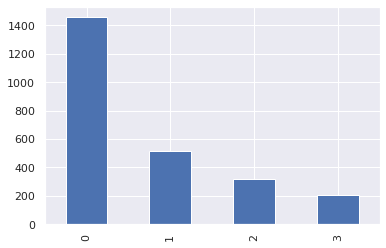

In [22]:
# distribution of topics in statements

sns.set(rc= {'figure.figsize': (5,3)})
sns.set_style('darkgrid')

df_orig.major_lda_topic.value_counts().plot(kind='bar')

In [23]:
keywords_openai = '''AI
'''

In [24]:
keywords_openai

'AI\n'

In [ ]:
openai.api_key = os.getenv("OPENAI_API_KEY")

response = openai.Completion.create(
model="text-davinci-002",
prompt="Topic (of maximum 2 Words) for these keywords: %s"%keywords_openai,
temperature=0.7,
max_tokens=256,
top_p=1,
frequency_penalty=0,
presence_penalty=0,
stop=["\"\"\""]
)
"""